In this notebook we analyze data using pandas with raw Python.

# Data load and processing

In [1]:
PRINT_THINGS = True
USING_CLUSTER = False # Uses HDFS and Spark 1.6
AS_A_SERVER_SCRIPT = False # No GUI, implies USING_CLUSTER = True

import pandas as pd

In [2]:
### Core modular functions
SYS_CACHE_LINE_SIZE = 64

# Gets insts samples only
def get_inst_data_only(dataset):
    ins = dataset[dataset.TYPE == "I"].drop("TYPE", axis=1)
    ins.reset_index(drop=True, inplace=True) # So indexing "0" means new first row and so on
    return ins

# inst_data must only contain instruction samples
def create_increments(inst_data):
    ncpus = max(inst_data.CPU)+1
    last_inst = ncpus * [0]
    last_req_dr = ncpus * [0]
    last_time = ncpus * [0]

    for index, row in inst_data.iterrows():
        temp_inst = row["INST"]
        temp_req_dr = row["REQ_DR"]
        temp_time = row["TIME_E"]
        temp_cpu = row["CPU"]

        # It is the first datum of the cpu, so it is set to zero
        if last_time[temp_cpu]==0:
            inst_data.set_value(index, "INST", 0)
            inst_data.set_value(index, "REQ_DR", 0)
            inst_data.set_value(index, "TIME_E", 0)
        else:
            inst_data.set_value(index, "INST", temp_inst - last_inst[temp_cpu])
            inst_data.set_value(index, "REQ_DR", temp_req_dr - last_req_dr[temp_cpu])
            inst_data.set_value(index, "TIME_E", temp_time - last_time[temp_cpu])
        inst_data.set_value(index, "oi", temp_inst / float(temp_req_dr*SYS_CACHE_LINE_SIZE))
        inst_data.set_value(index, "gis", temp_inst / float(temp_time))

        last_inst[temp_cpu] = temp_inst;
        last_req_dr[temp_cpu] = temp_req_dr;
        last_time[temp_cpu] = temp_time;
        
    # Makes future aggregation lighter by dropping unnecessary (at this point) fields
    return inst_data.drop(["CPU"], axis=1)
        
# create_increments(inst_data) should be called before
# Builds the equivalent of temp_tid_list: aggregation of inst data by TID
def get_aggregated_data(inst_data):
    
    # Sums desired fields: INST, TIME_E and REQ_DR
    agg = inst_data.drop(["PID","TIME"], axis=1).groupby("TID").sum()

    for index, row in agg.iterrows():
        temp_inst = row["INST"]
        temp_elapsed = row["TIME_E"]
        temp_req_dr = row["REQ_DR"]

        # Gigainsts
        gis = 0
        if temp_elapsed > 0: 
            gis = temp_inst / float(temp_elapsed)

        # Insts per byte
        oi = 0
        if temp_req_dr > 0:
            oi = temp_inst / float(temp_req_dr*SYS_CACHE_LINE_SIZE)

        agg.set_value(index, "oi", oi)
        agg.set_value(index, "gis", gis)

    # Drops unnecessary (at this point) fields
    agg.drop(["TIME_E","INST","REQ_DR"], inplace=True, axis=1)
    
    return agg


## Plot modular functions

In [3]:
# Sets up the environment
import matplotlib.pyplot as plt
if AS_A_SERVER_SCRIPT:
    plt.switch_backend("agg") # Necessary when a GUI does not exists
else:
    %matplotlib inline
import matplotlib.patches as mpatches

In [4]:
ROOFS = [
    # Based on spec sheets, for each core
    {
        "max_ginsts": 4*1.8,
        "max_throughput": 1.85,
        "line_colour": "r"
    },
    # Given by "Empirical Roofline Tool", for all the system. Must be divided by the number of cores
    {
        "max_ginsts": 10, #88.11 / 16,
        "max_throughput": 0.9, #40.76 / 16,
        "line_colour": "b"
    }
]

def draw_roof(r):
    max_g = r["max_ginsts"]
    max_t = r["max_throughput"]
    c = r["line_colour"]
    
    # Straight line: x varies from "max_throughput" to INF, while y ("max_throughput") does not vary
    r_x = [max_t, 100]
    r_y = [max_g, max_g]
    plt.plot(r_x, r_y, c)
    
    # Line with slope: x varies from 0 to "max_throughput", y varies from 0 to "max_ginsts"
    r_x = [0, max_t]
    r_y = [0, max_g]
    plt.plot(r_x, r_y, c)
    
def draw_roofs():
    for r in ROOFS:
        draw_roof(r)

# Plots data in a scatter
def plot_data(x, y, labels=[], colors=None, legend=None, log_scale=[], \
              xmin=None, ymin=None, xmax=None, ymax=None, circles=[], filename = "fig.png"):
    axs = plt.gca()
    
    plt.scatter(x, y, c = colors, linewidth = 0, edgecolor="") # Main call
    plt.gcf().set_size_inches(16.8, 10.5)
    
    if "y" in log_scale:
        axs.set_yscale("log", basey=2)
    if "x" in log_scale:
        axs.set_xscale("log", basex=2)
    axs.set_xlabel("Operational intensity (Insts/byte)", fontsize=20)
    axs.set_ylabel("GInsts/s", fontsize=20)
    
    # Ticks font size
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    
    # For clustering plotting
    for circle in circles:
        axs.add_artist(circle)

    # Adds text to point
    for i, txt in enumerate(labels):
        axs.annotate(txt, (x[i], y[i]), xytext = (0, -20), size = 8,
            textcoords = "offset points", ha = "center", va = "bottom",
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5)            
        )
    
    draw_roofs()
    
    if xmin is None:
        xmin = 0.9*min(x)
    if xmax is None:
        xmax = 1.02*max(x)
    if ymin is None:
        ymin = 0.9*min(y)
    if ymax is None:
        reference = min( max(y), ROOFS[0]["max_ginsts"] )
        ymax = 1.02*reference
        
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)
    
    if legend is not None:
        plt.legend(handles=legend, loc="upper left")
    
    # Shows everything
    plt.show()
    
    if AS_A_SERVER_SCRIPT:
        plt.savefig(filename, bbox_inches="tight")
        plt.gcf().clear()
    
# We associate PID to random color, trying not to use similar colours
def associate_colors_to_pids(pids, tol = 50):
    from random import randint
    
    colors = {}
    for pid in pids:
        
        # Loop where we evalue the similarity between the colors
        discard = True
        while discard == True:
            rand_col = "#" + '%06X' % randint(0, 0xFFFFF0)

            discard = False
            for hex_str in colors.values():

                # We extract red, green and blue individual values
                v1 = [int(rand_col[1+i: 3+i], 16) for i in range(0,6,2)]
                v2 = [int(hex_str[1+i: 3+i], 16) for i in range(0,6,2)]
                
                # We define their difference by adding the absolute subtract of their parts
                diff = sum(map(lambda v1, v2: abs(v1-v2), v1, v2))
                
                if diff < tol:
                    discard = True
                    break
                    
        colors[pid] = rand_col
        
    return colors

# We associate PID to random color
def associate_colors_to_pids_old(pids, tol = 0):
    from random import randint
    
    colors = {}
    for pid in pids:
        colors[pid] = "#" + '%06X' % randint(0, 0xFFFFFF)
    
    return colors
    
def get_rand_colors_to_plot(pids, tid_pmap, tid_list):
    c_map = associate_colors_to_pids(pids) # Maps PID->color

    # We will create tid_cmap (TID->color) using tid_pmap (TID->PID) and c_map (PID->color)
    tid_cmap = {}
    for tid, pid in tid_pmap.iteritems():
        color = c_map[pid]
        tid_cmap[tid] = color

    # Final colors and legend array to be passed to the plot function
    point_colors = [tid_cmap[tid] for tid in tid_list]

    # Useful for legend plotting
    legend = [mpatches.Patch(color=c, label=p) for p, c in c_map.iteritems()]
    
    return point_colors, legend

Now, we actually begin the work:

In [5]:
## Imports data
df = pd.read_csv("03-05-2017_14-44-00.csv")
#df = pd.read_csv("profile_4luC_crossed_migs.csv")

# Drops a prori unnecessary columns
#df.drop(["IIP","SAMPLE_ADDR","WEIGHT","DSRC","MEM_OPS","TIME_R","SSE_D","SSE_S"],inplace=True,axis=1)
df.drop(["IIP","SAMPLE_ADDR","WEIGHT","DSRC","MEM_OPS","TIME_R"],inplace=True,axis=1) # For real examples

print df.loc[0:2,] # Shows three first rows

  TYPE    PID    TID              TIME  CPU        TIME_E  INST  REQ_DR
0    M  31533  31533  4680104132922865   10  587613360878     0       0
1    M  31533  31533  4680104134116800   10  587614554960     0       0
2    M  31533  31533  4680104135299138   10  587615737212     0       0


In [6]:
## Gets inst data and creates increments
inst_df = get_inst_data_only(df)
print inst_df.loc[0:2,] # Shows two first rows (only insts now!)

print "Going to create increments."
    
# Creates increments
inst_incr = create_increments(inst_df.copy())
print inst_incr.loc[0:2,] # After creating increments

     PID    TID              TIME  CPU        TIME_E           INST  \
0  31568  31568  4680103905126434    0  587385836162  1277400000036   
1  31568  31568  4680103949227776    0  587429937854  1277400000036   
2  31568  31568  4680103979831212    0  587460541524  1277400000036   

        REQ_DR  
0  17537812345  
1  17537812345  
2  17537812345  
Going to create increments.
     PID    TID              TIME    TIME_E  INST  REQ_DR        oi       gis
0  31568  31568  4680103905126434         0     0       0  1.138077  2.174720
1  31568  31568  4680103949227776  44101692     0       0  1.138077  2.174557
2  31568  31568  4680103979831212  30603670     0       0  1.138077  2.174444


             oi       gis
TID                      
1065   1.279643  0.001234
1068   0.000000  0.000000
1070   0.806694  0.001421
31194  0.381983  3.476325
31462  0.880621  5.365282


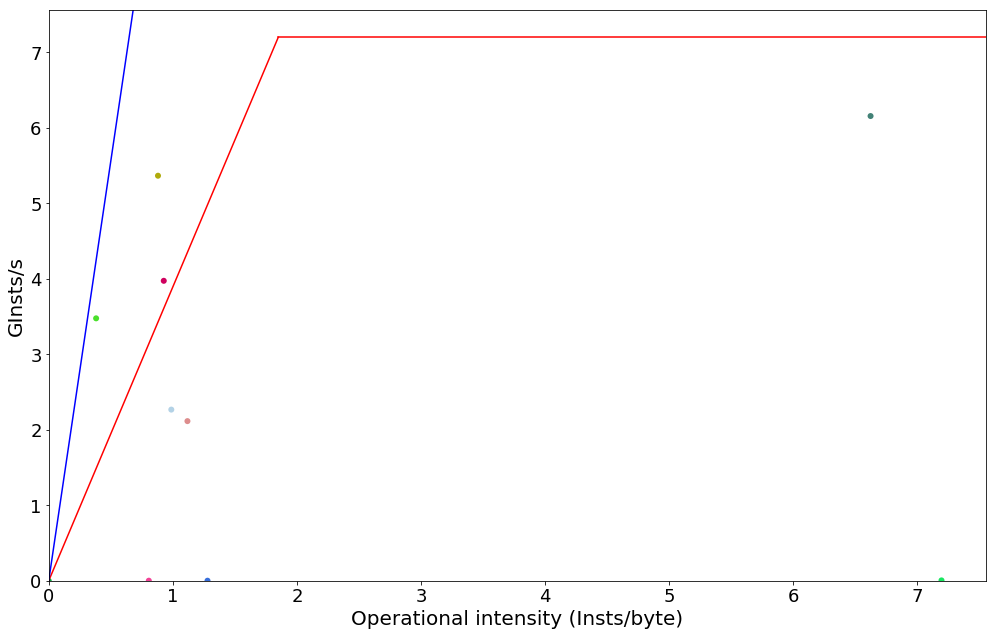

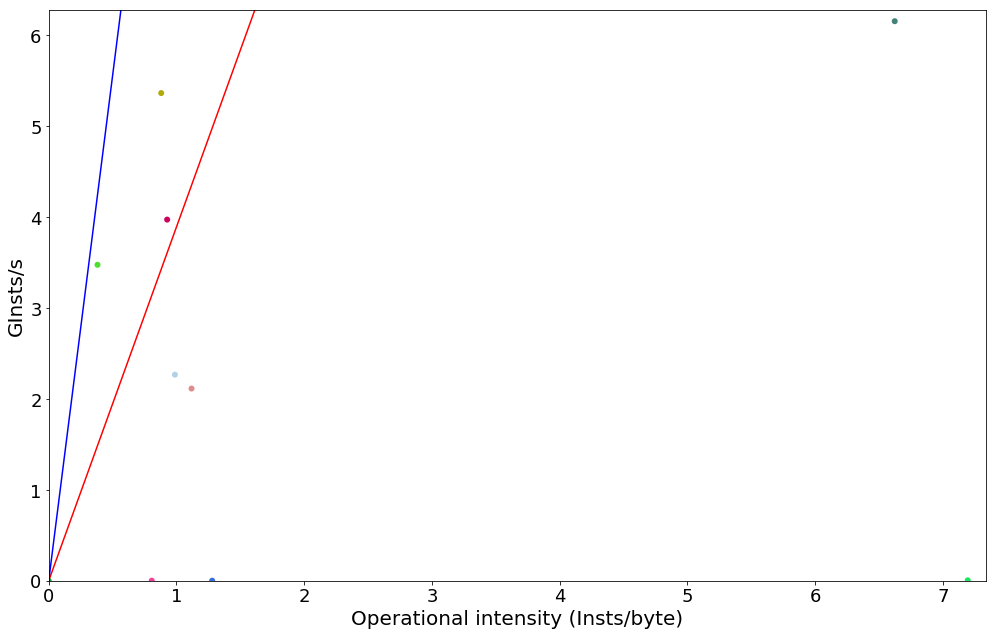

In [7]:
def get_tid_map(inst_data):
    # Groups by PID and then for TID, to get every PID-TID association
    agg_pid = inst_data.groupby(["PID", "TID"])

    tid_map = {}
    for t in agg_pid.indices:
        pid = t[0]
        tid = t[1]
        tid_map[tid] = pid

    return tid_map

tid_map = get_tid_map(inst_df)

###

## Aggregates inst data and plots all the TIDs
agg = get_aggregated_data(inst_incr)
print agg.head()

tids = list(agg.index)
ois = list(agg["oi"])
giss = list(agg["gis"])

pids = list(set(inst_df.PID))

# Now, let's plot with colors!
c, l = get_rand_colors_to_plot(pids, tid_map, tids)
plot_data(ois, giss, colors=c, xmin = 0.0, xmax = max(1.05*max(ois),2*ROOFS[0]["max_throughput"]), \
          ymin = 0.0, ymax = 1.05*ROOFS[0]["max_ginsts"], filename="aggplot.png")
plot_data(ois, giss, colors=c, filename="aggplot_zoom.png")

# Manual zoom with fake clustering and no legend
cs = []
cs.append(plt.Circle((0.8, 0.2), 0.6, color='g', alpha=0.2))
cs.append(plt.Circle((6.9, 0.2), 0.5, color='r', alpha=0.2))
#plot_data(ois, giss, colors=c, circles=cs, xmin=0, ymin=0, ymax=0.06, xmax=7.5)

31498


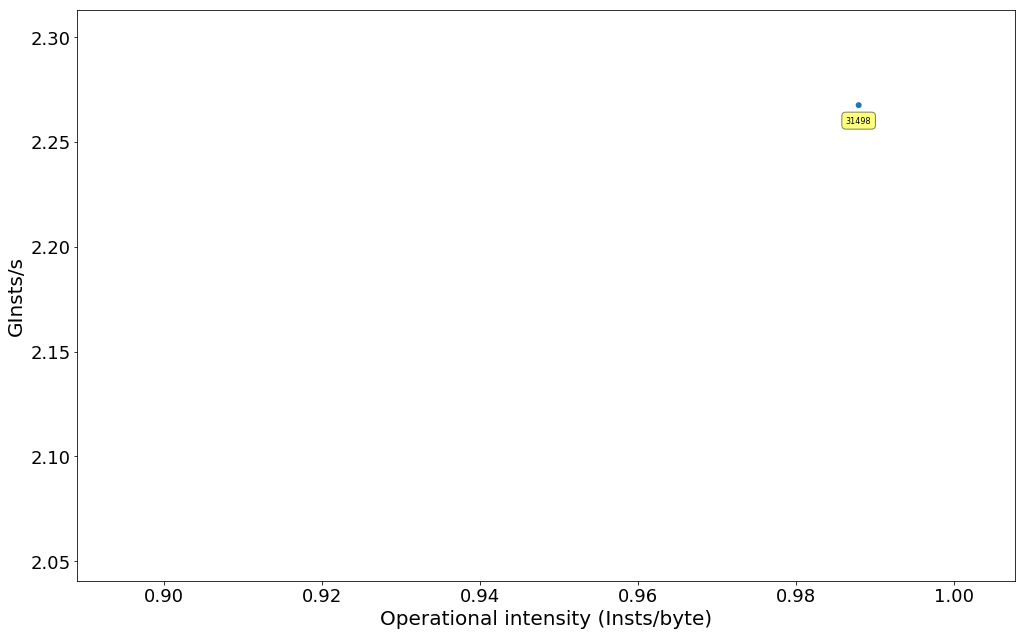

In [8]:
# Some utility functions to filter and plot data by PID

# key: PID, value: TID array
def get_pid_map(inst_data):
    # Groups by PID and then for TID, to get every PID-TID association
    agg_pid = inst_data.groupby(["PID", "TID"])

    pid_map = {}
    for t in agg_pid.indices:
        pid = t[0]
        tid = t[1]
        if pid not in pid_map.keys(): # Creates TID list for new PID
            pid_map[pid] = []
        pid_map[pid].append(tid)

    return pid_map
    
# Useful to reduce the number of plotted points
def filter_data_by_pid(pid, pmap, agg_data):
    tids_from_pid = pmap[pid]

    subdata = agg_data.loc[tids_from_pid]
    ois = list(subdata["oi"])
    giss = list(subdata["gis"])
    
    return ois, giss, tids_from_pid

###

m = get_pid_map(inst_df)
pids = m.keys()
test_pid = pids[3]
print test_pid

ois_pid, giss_pid, subtids = filter_data_by_pid(test_pid, m, agg)

plot_data(ois_pid, giss_pid, subtids)

## Time plot

We will do some stuff to plot, for each PID (different lines), the evolution of instructions over time. The first thing to take into account is that sample timestamp does not match actual system timestamp. We have to subtract the minimum timestamp to each sample and then we can add a reference timestamp, which we don't have in this case. Then, we do some calculations to know which (and how many) custom X tick labels to use.

In [9]:
inv_micr = 10 ** -9 # Precalculated
total_min = inst_df.min()["TIME"] # First timestamp. Reference
total_max = inst_df.max()["TIME"] # Simply to know how many hours/minutes to plot
base_timestamp = 0 # Execution script timestamp. 0 if not known
value_to_add = -total_min + base_timestamp
diff_secs = (total_max - total_min) * inv_micr

TIME_MAGS = [
    {
        "label": "day",
        "factor": 60*60*24,
    },
    {
        "label": "h",
        "factor": 60*60,
    },
    {
        "label": "min",
        "factor": 60,
    },
    {
        "label": "sec",
        "factor": 1,
    },
]

# Gets the most fitting magnitude: the biggest that allows to show at least one label
mag_to_use = None
mag_value = None
for i, elm in enumerate(TIME_MAGS):
    mag_value = int(diff_secs / elm["factor"])
    if mag_value != 0:
        mag_to_use = elm
        break

# Minute ticks
custom_xtick_data = {}
custom_xtick_data["values"] = [mag_to_use["factor"]*m for m in range(mag_value+1)]
custom_xtick_data["labels"] = [str(m) + " " + mag_to_use["label"] for m in range(mag_value+1)]
custom_xtick_data["labels"][0] = "Begin"

In [10]:
def time_increments(inst):
    for index, row in inst.copy().iterrows(): # Issue: does not use an actual copy
        temp_time = row["TIME"]
        inst.set_value(index, "TIME", (temp_time + value_to_add) * inv_micr)
    return inst


time_incr = time_increments(inst_incr)

print time_incr.loc[0:2,] # Shows three first rows

     PID    TID  TIME    TIME_E  INST  REQ_DR        oi       gis
0  31568  31568     0         0     0       0  1.138077  2.174720
1  31568  31568     0  44101692     0       0  1.138077  2.174557
2  31568  31568     0  30603670     0       0  1.138077  2.174444


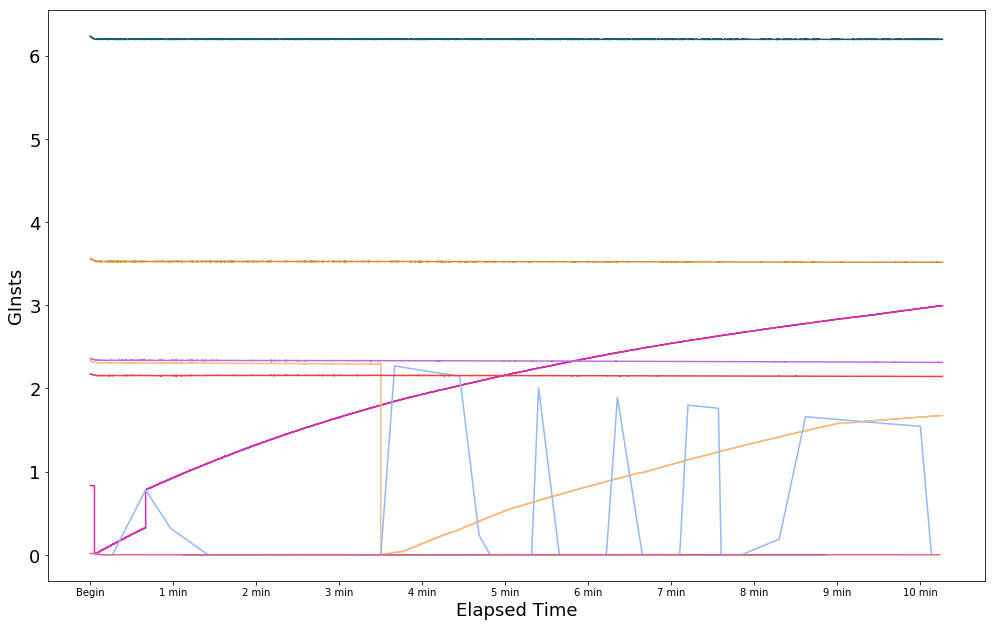

In [11]:
# Each call of this function plots a line, associated to a PID
def plot_pid_time(inst_data, pid, color):    
    x = []
    y = []
    pid_data = inst_data[inst_data["PID"] == pid] # Filters data for desired PID

    for i, r in pid_data.iterrows():
        x.append(r["TIME"])
        y.append(r["gis"])
        
    plt.plot(x, y, color)
        
# One line per PID: insts against timestamp
def plot_time(inst_data, plot_legend=True, xtick_data=None):
    axs = plt.gca()

    plt.gcf().set_size_inches(16.8, 10.5)
    #axs.set_yscale("log")
    axs.set_xlabel("Elapsed Time", fontsize=18)
    axs.set_ylabel("GInsts", fontsize=18)
    
    if xtick_data is not None:
        axs.set_xticks(xtick_data["values"])
        axs.set_xticklabels(xtick_data["labels"])
    
    # Bigger y ticks
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    
    MAX_PIDS = 15 # A lot of lines would make the graphic a mess
    
    p_map = associate_colors_to_pids(pids[:MAX_PIDS], tol = 100)
        
    legend = []
    
    # Loop for main calls
    for i, (pid, col) in enumerate(p_map.iteritems()):
        if i == MAX_PIDS:
            break
        plot_pid_time(inst_data, pid, col)
        legend.append(mpatches.Patch(color=col, label=pid)) # For legend plotting
    
    if plot_legend:
        plt.legend(handles=legend, loc="upper left")
        
    # Avoids some strange figures due to rare peaks
    ylims = list(axs.get_ylim())
    ylims[1] = min(ylims[1], ROOFS[0]["max_ginsts"])
    axs.set_ylim(ylims)
    
    # Shows everything
    plt.show()
    
    if AS_A_SERVER_SCRIPT:
        plt.savefig("timeplot.png", bbox_inches="tight")
        plt.gcf().clear()

plot_time(time_incr, plot_legend = False, xtick_data = custom_xtick_data)

In [12]:
print inst_incr.loc[0:2,] # Shows three first rows

     PID    TID  TIME    TIME_E  INST  REQ_DR        oi       gis
0  31568  31568     0         0     0       0  1.138077  2.174720
1  31568  31568     0  44101692     0       0  1.138077  2.174557
2  31568  31568     0  30603670     0       0  1.138077  2.174444


## RM evolution for one TID

In [13]:
# From: http://bsou.io/posts/color-gradients-with-python
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
        "r":[RGB[0] for RGB in gradient],
        "g":[RGB[1] for RGB in gradient],
        "b":[RGB[2] for RGB in gradient]}

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initialize a list of the output colors with the starting color
    RGB_list = [s]
    # Calculate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)

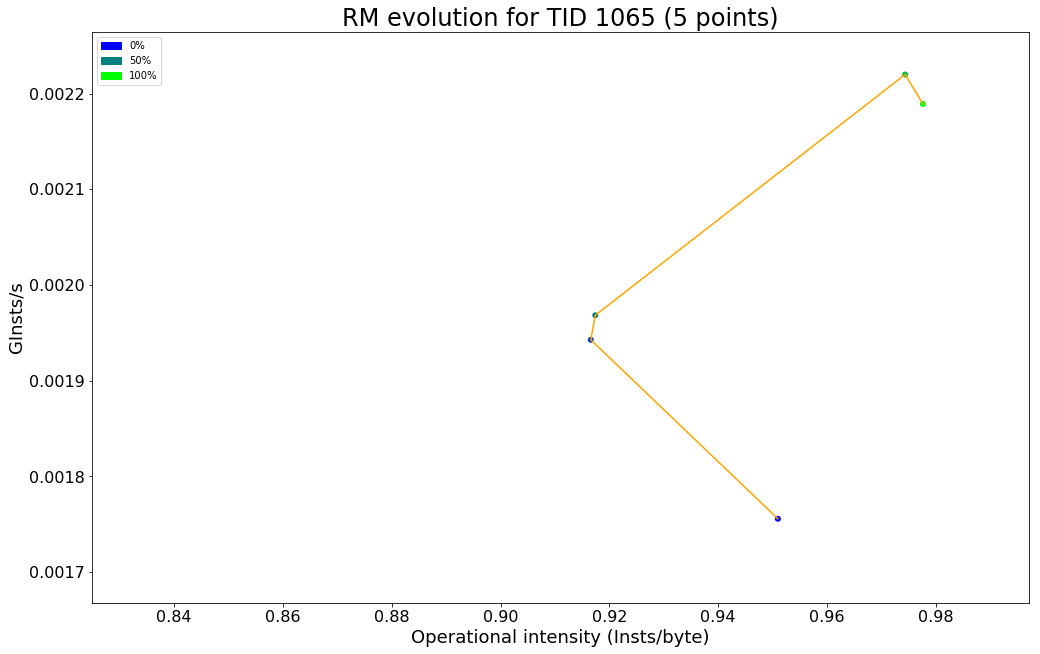

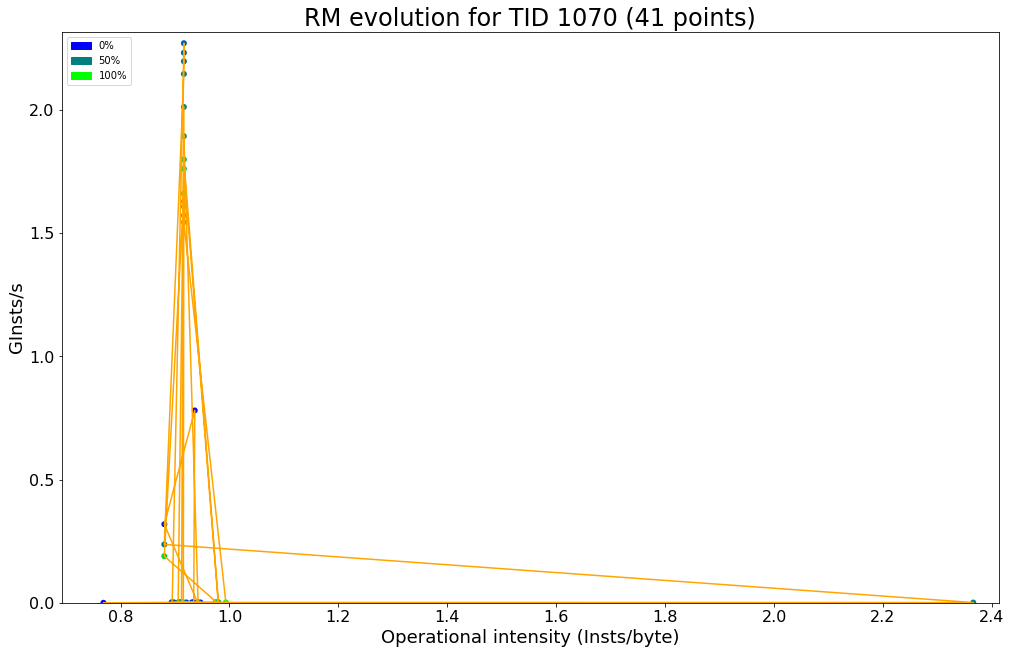

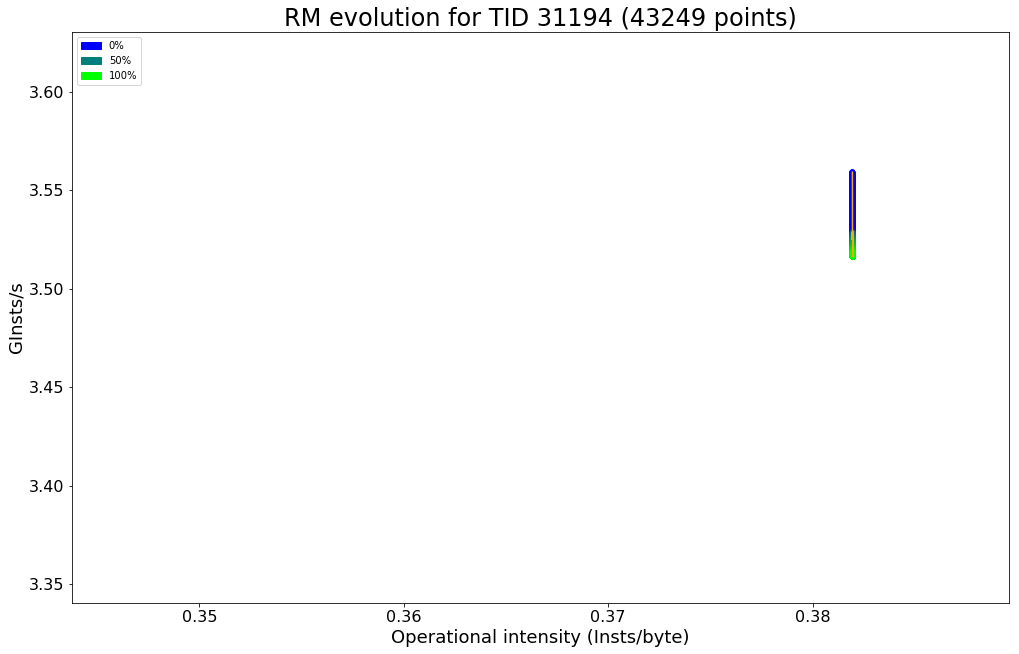

In [14]:
def plot_rm_ev(inst_data, tid, legend=False, log_scale=[], xmin=None, ymin=None, xmax=None, ymax=None):
    x = []
    y = []
    tid_data = inst_data[inst_data["TID"] == tid] # Filters data for desired TID

    for i, r in tid_data.iterrows():
        x.append(r["oi"])
        y.append(r["gis"])
        
    num_of_points = len(x)
    
    # No pointless graphics
    if num_of_points == 1:
        return 0
    
    # Gets "number of points" colors that are a gradient from blue to green
    cs = linear_gradient("#0000ff", "#00ff00", num_of_points)["hex"]
    
    axs = plt.gca()
    plt.gcf().set_size_inches(16.8, 10.5)
    #axs.set_yscale("log")
    axs.set_xlabel("Operational intensity (Insts/byte)", fontsize=18)
    axs.set_ylabel("GInsts/s", fontsize=18)
    
    # Bigger ticks
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
        
    if "y" in log_scale:
        axs.set_yscale("log", basey=2)
    if "x" in log_scale:
        axs.set_xscale("log", basex=2)
        
    draw_roofs()
    
    # Main call: points as a scatter and a additional plot for a line that joins them
    plt.scatter(x, y, c = cs, linewidth = 0, edgecolor="")
    plt.plot(x, y, "orange")

    if xmin is None:
        xmin = 0.9*min(x)
    if xmax is None:
        xmax = 1.02*max(x)
    if ymin is None:
        ymin = 0.95*min(y)
    if ymax is None:
        ymax = 1.02*max(y)
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)
    
    # Optional legend plotting
    if legend:
        indexes = [0, num_of_points/2, num_of_points-1]
        legend_labels = ["0%","50%","100%"]
        legend = [mpatches.Patch(color=cs[big], label=legend_labels[little]) for little, big in enumerate(indexes)]
        plt.legend(handles=legend, loc="upper left")
        
    plt.title("RM evolution for TID " + str(tid) + " (" + str(num_of_points) + " points)", fontsize=24)
    
    # Shows everything
    plt.show()
    
    if AS_A_SERVER_SCRIPT:
        plt.savefig("RM_ev_TID_" + str(tid) + ".png", bbox_inches="tight")
        plt.gcf().clear()
    
    return 1

MAX_RM_EVS_FIGURES = 3
generated = 0
for tid in tids:
    generated += plot_rm_ev(inst_incr, tid, legend=True)
    if generated == MAX_RM_EVS_FIGURES: # We don't need ALL the graphics
        break